In [215]:
using PyPlot;
using ImageFiltering; 
using FFTViews;

function safe_div(nume,denom)
	""" Handles division in the case of a zero denominator. 
    
	Parameters
	----------
	nume: ND Array
		Numerator to be divided. 
	denom: ND Array
		Denominator. 

	Returns
	-------
	result: ND Array
		Result of the division.  
	"""
    
	result = nume./denom
	result[isnan(result)] = 0 

	return result
end


function convolution(conc,conc_filter):
	""" Replicates the Python sp.ndimage.convolve1d function.
    
	Parameters
	----------
	conc: 1D Array
		Input vector to be convoluted. 
	conc_filter: 1D Array
		Convolution filter.
    
	Returns
	-------
	out: 1D Array
		Result of the convolution. 
	"""
    
	n=length(conc)
	m=length(conc_filter)

	padleft=ceil(Int32,m/2)-1
	padright=floor(Int32,m/2)

	conc =append!(zeros(padleft),conc)
	conc = append!(conc,zeros(padright))
	out = zeros(n)
    
	for i in 1:n
		for j in 1:m
			out[i] += conc[i+j-1]*conc_filter[m-j+1]
		end
	end
	return out
end


function report_progress(i::Int,iterations::Int,tstart::Float64)
	""" Prints to screen the model progress. 

	Parameters
	----------
	i: int 
		Current iteration of the model.

	iterations: int 
		Number of iterations set to run. 

	tstart: float 
		Time of starting the model. 
	"""
    
	progress = ((i)*100)/iterations
	t = time()
	tpassed = (t-tstart)/60
	time2go = ((tpassed/progress)*100) - tpassed
	print("$(@sprintf("%.3f",progress))% completed.  Time passed: $(@sprintf("%.3f",tpassed)) mins.    Expected time left: $(@sprintf("%.3f",time2go))  \r")
	flush(STDOUT)
end

report_progress (generic function with 1 method)

In [236]:
const NUM_MARKERS = 3
const FRAME_RATE = 1

const DECAY_CONST = 0.006 	 			# decay constant
const DIFF_CONST = 0.3 					# diffusion constant
const PRE_CONC_SOURCE_CONST = 100

const PRE_SHEET_LEN = 20 					# N_R in paper
const POST_SHEET_LEN = 20					# N_T in paper
const NUM_INIT_CONTACTS = 10				# n_0 in paper
const INIT_BIAS = 15						# N_L in paper
const TOTAL_SYN_WEIGHT = 1
const dt = 0.5
const DIFF_ITERATIONS = 10
const STAB_THRESH = 0.001
const CONC_THRESH = 0.01 					# epsilon in paper
const WEIGHT_UPDATE_CONST = 0.01			# h in paper
const MEAN_SIM_CONST = 0.03				# k in paper
const SPROUT_CONST = 0.01
const DISCARD_CONST = 0.005	
const STRONG_SYN_CONST = 0.02;		

In [237]:
function gen_init_connections(cell::Int)
	""" Creates randomised connections to cells within the postsynaptic
	chain according to the method outlined in Willshaw, von der Malsburg (1979).  

	Parameters
	----------
	cell: int 
		Position of presynaptic cell. 

	Returns
	-------
	weights: 1D Array
		Synaptic weights for each possible connection between the cell and
		postsynaptic chain.
	"""
	weights = zeros(PRE_SHEET_LEN)

	start = ceil(Int64,cell*((POST_SHEET_LEN - INIT_BIAS)/PRE_SHEET_LEN)) 
	last = floor(Int64,start + INIT_BIAS)

	if (last >POST_SHEET_LEN) 
		last = POST_SHEET_LEN
	end

	connections = rand(start:last,NUM_INIT_CONTACTS)
	weights[connections] = TOTAL_SYN_WEIGHT/NUM_INIT_CONTACTS

	return weights
end


function init_syn_weights()
	""" Generates array containing initial randomised connections between
	pre and postsynaptic chain. 

	Returns
	-------
	syn_weights: 2D Array
		Initial synaptic weights between each cell in pre and postsynaptic 
		chain.	

	"""
	syn_weights = zeros((PRE_SHEET_LEN,POST_SHEET_LEN))
	for cell in 1:PRE_SHEET_LEN
		syn_weights[cell,:] = gen_init_connections(cell)
	end   
    
	return syn_weights
end

init_syn_weights (generic function with 1 method)

In [238]:
function init_marker_source()
	""" Places initial marker source in presynaptic chain. Each marker source
	is positioned evenly across the presynaptic chain. 

	Returns
	-------
	pre_marker_source: 2D Array
		Source of each marker in each position of the presynaptic chain.  
	"""
	pre_marker_source = zeros((PRE_SHEET_LEN,NUM_MARKERS))
	pre_marker_source[2,1] = PRE_CONC_SOURCE_CONST 
	pre_marker_source[PRE_SHEET_LEN-1,NUM_MARKERS] = PRE_CONC_SOURCE_CONST 
	spacing = floor(Int64,(PRE_SHEET_LEN-2)/(NUM_MARKERS))

	prev = 0
	m = 1
	for k =1:(NUM_MARKERS-2)
		i = prev + spacing
		pre_marker_source[i,m] = PRE_CONC_SOURCE_CONST 
		prev = i
		m+=1
	end
	return pre_marker_source
end

init_marker_source (generic function with 1 method)

In [239]:
function initialise():
	""" Initialises components of the model. 

	Returns
	-------
	syn_weights: 2D Array
		Initial random synaptic weights between each cell in retina and tectum. 

	pre_conc: 2D Array
		Initial concentrations of each marker at each position in presynaptic chain.

	post_conc: 2D Array
		Initial concentrations of each marker at each pos in postsynaptic chain.

	pre_marker_source: 2D Array
		Source of each marker at each position in presynaptic chain. 

	post_marker_source: 2D Array
		Initial source of each marker at each position in postsynaptic chain. 

	"""
	syn_weights = init_syn_weights()

	pre_conc = zeros((PRE_SHEET_LEN,NUM_MARKERS)) 	
	post_conc = zeros((POST_SHEET_LEN,NUM_MARKERS))	
	
	pre_marker_source = init_marker_source()
	post_marker_source = zeros((POST_SHEET_LEN,NUM_MARKERS))

	return (syn_weights,pre_conc,post_conc,pre_marker_source,post_marker_source)
end

initialise (generic function with 1 method)

In [240]:
function update_pre_conc(conc,marker_source)
	""" Applies diffusion equation to presynaptic marker concentrations.

	Parameters
	----------
	conc: 2D Array 
		Concentration of each marker at each position in presynaptic chain.

	marker_source: 2D Array
		Source of each marker at each position in presynaptic chain.

	Returns
	-------
	conc: 2D Array
		New concentrations of each marker in each presynaptic chain position. 

	"""
	conc_change = zeros(size(conc))
	average_change = 1
	a = DECAY_CONST
	d = DIFF_CONST

	conc_filter = [d,(-2*d)-a,d]

	while(average_change > STAB_THRESH)
		for i in 1:NUM_MARKERS
			conc_change[:,i] = convolution(conc[:,i],conc_filter)
		end
		conc_change[1,:] = -DECAY_CONST*conc[1,:] + DIFF_CONST*(-conc[1,:] + conc[2,:])
 		x = PRE_SHEET_LEN
		conc_change[x,:] = -DECAY_CONST*conc[x,:] + DIFF_CONST*(conc[(x-1),:]- conc[x,:])
		conc_change+= marker_source 
		percent_change = safe_div(conc_change,conc) 
		average_change = mean(percent_change)
		conc += conc_change*dt
	end
	return conc
end

update_pre_conc (generic function with 1 method)

In [241]:
function update_post_marker(syn_weights,norm_pre_conc)
	""" Computes source of each marker in each postsynaptic 
	cell, induced from the presynaptic chain. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	norm_pre_conc: 2D Array
		Normalised concentrations of each marker in each cell of presynaptic
		chain. 

	Returns
	-------
	post_marker_source: 2D Array
		Updated source of each marker in each cell of postsynaptic chain.

	"""
	post_marker_source = transpose(syn_weights)*norm_pre_conc 
	return post_marker_source
end

update_post_marker (generic function with 1 method)

In [242]:
function update_post_conc(conc, marker_source)
	""" Applies diffusion equation to postsynaptic marker concentrations.

	Parameters
	----------
	conc: 2D Array
		Concentration of each marker in each position in postsynaptic chain. 

	marker_source: 2D Array
		Source of each marker at each position in postsynaptic chain. 

	Returns
	-------
	conc: 2D Array
		Updated concentrations of each marker after diffusion across 
		neighbouring cells. 
	"""
	conc_change = zeros(conc)
    
	a = DECAY_CONST
	d = DIFF_CONST

	conc_filter = [d,(-2*d)-a,d]

	for i in 1:DIFF_ITERATIONS
		for i in 1:NUM_MARKERS 
			conc_change[:,i] = convolution(conc[:,i],conc_filter)
		end
		conc_change+= marker_source
	end
	conc += conc_change*dt
	return conc
end

update_post_conc (generic function with 1 method)

In [243]:
function norm_conc(conc):
	""" Normalises marker concentrations and elimnates markers 
	with sub-threshold concentrations. 

	Parameters
	----------
	conc: 2D Array
		Marker concentrations in each cell of the pre/postsynaptic chain. 

	Returns
	-------
	norm_conc: 2D Array
		Normalised concentrations of each marker in pre or postsynaptic chain. 

	"""
	new_conc = zeros(length(conc[:,1]),NUM_MARKERS)
	denom = sum(conc,2)
	for i in 1:NUM_MARKERS
		new_conc[:,i] = transpose(safe_div(transpose(conc)[i,:],denom[:,1]))
	end
	new_conc[find(x -> x < CONC_THRESH, new_conc)] = 0
	return new_conc
end

norm_conc (generic function with 1 method)

In [244]:
function calc_similarity(pre_conc,post_conc,x,y)
	""" Calculates the similarity between between two given cells. 
	See Willshaw, von der Malsburg (1979) for definition of similarity.

	Note: Pre and postsynaptic concentrations are normalised within the 
	function so no need to pass in normalised values. 

	Parameters
	----------
	pre_conc: 2D Array
		Concentration of each marker at each presynaptic chain position. 

	post_conc: 2D Array
		Concentration of each marker at each postsynaptic chain position. 

	x: int 
		Position of presynaptic cell. 

	y: int 
		Position of postsynaptic cell. 

	Returns
	-------
	similarity: int 
		Similarity of the two cells.  
	"""
	pre_molecules = find(item -> item != 0,pre_conc[x,:])
	post_molecules = find(item -> item != 0,post_conc[y,:])
	common_molecules = intersect(pre_molecules,post_molecules) # fine

	denom = sum(pre_conc[x,common_molecules])
	if(denom == 0)
		norm_pre = zeros(size(pre_conc[x,:]))
	else
		norm_pre = pre_conc[x,:]/denom #fine
	end

	denom = sum(post_conc[y,common_molecules])
	if(denom ==0)
		norm_post = zeros(size(post_conc[y,:]))
	else
		norm_post = post_conc[y,:]/denom
	end

	norm_pre[find(item -> item < CONC_THRESH,norm_pre)] = 0
	norm_post[find(item -> item < CONC_THRESH, norm_post )] = 0  

	mat = hcat(norm_pre,norm_post)'
	similarity = sum(minimum(mat,1))

	return similarity
end

calc_similarity (generic function with 1 method)

In [245]:
function update_weights(syn_weights,pre_conc,post_conc)
	""" Updates synaptic weights as a function of the similarity between
	each pre and postsynaptic cell. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	pre_conc: 2D Array
		Concentration of each marker in each cell of the presynaptic chain.

	post_conc: 2D Array
		Concentration of each marker in each cell of the postsynaptic chain.

	Returns
	-------
	syn_weights: 2D Array
		Updated synaptic weights after adjusting for marker similarities in 
		pre and postsynaptic chain. 

	"""
	weight_change = zeros(size(syn_weights))

	for x in 1:PRE_SHEET_LEN
		sim = zeros(POST_SHEET_LEN)
		for y in 1:POST_SHEET_LEN
			sim[y] = calc_similarity(pre_conc,post_conc,x,y)
		end
      
		connections = find(item -> item != 0,syn_weights[x,:])
		mean_sim = (sum(sim[connections])/length(connections)) - MEAN_SIM_CONST
		weight_change[x,:] = WEIGHT_UPDATE_CONST*(sim - mean_sim)
		syn_weights[x,:] += weight_change[x,:]
	end
    
	syn_weights = norm_weights(syn_weights)

	return syn_weights
end

update_weights (generic function with 1 method)

In [246]:
function norm_weights(syn_weights)
	""" Normalises synaptic weights so that total weight available to 
	each fibre is constant. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	Returns
	-------
	syn_weights: 2D Array
		Updated, normalised synaptic weights. 
	"""
	syn_sum = sum(syn_weights,1)'
	denom = repeat(syn_sum',inner=(size(syn_weights)[1],1))
	syn_weights = (TOTAL_SYN_WEIGHT*syn_weights)./denom
	return syn_weights
end

norm_weights (generic function with 1 method)

In [247]:
function update_connections(syn_weights)
	""" Removes weak synapses and creates new connections adjacent
	to strong synapses. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	Returns
	-------
	new_weights: 2D Array
		Normalised synaptic weights after removal and addition of synapses. 

	"""
	syn_weights[find(x -> x < (DISCARD_CONST*TOTAL_SYN_WEIGHT), syn_weights)] = 0
	(xinds,yinds) = findn(syn_weights .> (STRONG_SYN_CONST*TOTAL_SYN_WEIGHT)) # finds strong syns

	for index=1:length(yinds)
		if((yinds[index] < POST_SHEET_LEN))
			if((syn_weights[xinds[index],yinds[index]+1]==0))
				syn_weights[xinds[index],yinds[index]+1] = SPROUT_CONST*TOTAL_SYN_WEIGHT
			end
		end
		if(yinds[index]-2 >= 0)
			if(syn_weights[xinds[index],yinds[index]-1]==0)
				syn_weights[xinds[index],yinds[index]-1] = SPROUT_CONST*TOTAL_SYN_WEIGHT
			end
		end
	end
	new_weights = norm_weights(syn_weights)
	return new_weights
end

update_connections (generic function with 1 method)

In [259]:
function run(iterations)
	""" Runs simulation of Marker Model. 

	Each simulation cycle consists of:
	1) Updating synaptic weights
	2) Adding/removing synapses
	3) Updating marker sources in postsynaptic chain
	4) Updating marker concentrations in postsynaptic chain
	
	Parameters
	----------
	iterations: int 
		Number of iterations to simulate model. 
	"""

	println("Running Marker Induction Model (1979)...")
	tstart = time()
	params = initialise()

	(syn_weights,pre_conc,post_conc,pre_marker_source,post_marker_source) = params
	iter_weights = zeros((floor(Int64,iterations/FRAME_RATE),PRE_SHEET_LEN,POST_SHEET_LEN))
	iter_weights[1,:,:] = syn_weights

	pre_conc = update_pre_conc(pre_conc,pre_marker_source)
	pre_conc = norm_conc(pre_conc) 

	for i=1:iterations
		post_marker_source = update_post_marker(syn_weights,pre_conc) 
		post_conc = update_post_conc(post_conc,post_marker_source) 
		post_conc = norm_conc(post_conc)  

		syn_weights = update_weights(syn_weights,pre_conc,post_conc) 
		syn_weights = update_connections(syn_weights)

		if(i%FRAME_RATE == 0)
			iter_weights[floor(Int,i/FRAME_RATE),:,:] = syn_weights
		end
		report_progress(i,iterations,tstart)
	end
	return iter_weights
end

run (generic function with 1 method)

In [255]:
iter_weights = run(5000);

Running Marker Induction Model (1979)...


# Visualisation

In [257]:
function plot_iteration(syn_weights)
	""" Displays synapses between between neurons in pre- and
	postsynaptic chain. The strength of each synapse is 
	indicated by the size of its marker. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 
	"""
    
	for i in 1:PRE_SHEET_LEN
		syns = findn(syn_weights[i,:])
		size = syn_weights[i,syns]*100
		PyPlot.scatter([i for j in 1:length(syns)],syns,s=size,c="k")
	end

	PyPlot.xlim([0,PRE_SHEET_LEN+1])
	PyPlot.ylim([0,POST_SHEET_LEN+1])
	PyPlot.xlabel("Presynaptic Cell Number")
	PyPlot.ylabel("Postsynaptic Cell Number")
	PyPlot.show()
end
            


function update_dist(val)
	""" Updates distribution plot to display synapses at a given
	iteration of the model simulation.

	Parameters
	----------
	val: int
		Iteration to display synapse distribution.
	"""
	ax = PyPlot.gca()
	ax[:set_aspect]("equal")
	val = Int(val/FRAME_RATE)
	syn_weights = weights[val,:,:]
	plot_iteration(syn_weights)
end


# Can't seem to get widgets working in JuliaBox. 
function plot_dist(iws)
	""" Sets up the figure and iteration slider for a synapse distribution
	plot. 
    
	Parameters
	----------
	iws: 3D Array
		Synaptic weights between each pre- and postsynaptic neuron at
		each frame of the model simulation.
	"""
	global weights
	PyPlot.figure()
	weights = iws
	PyPlot.interact(update_dist,val=IntSlider(min=0,
	max=len(weights[:,0,0])*FRAME_RATE -1,
	step=1,description="Iteration: "))
end


plot_dist (generic function with 1 method)

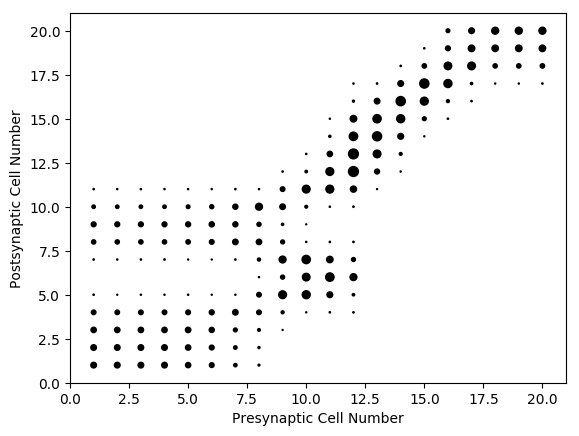

In [258]:
plot_iteration(iter_weights[2000,:,:])